# SIIM-COCOtoIce01-Kag


## Environment Setup
### Determine which version of CUDA is installed and select appropriate TORCH and MMCV libraries

In [ ]:
import torch
print(f"The preinstalled torch version is: {torch.__version__}")
print(f"The preinstalled CUDA version is: {torch.version.cuda}")

In [ ]:
!pip install fastai==2.3.1 --upgrade

In [ ]:
# Use for CUDA 10.x
# !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html --upgrade

# Use for CUDA 11.0
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html --upgrade    

## STOP!! - Restart Kernel & Clear Outputs

In [ ]:
!pip install torchtext==0.9.0 --upgrade

In [ ]:
import torch
print(f"The torch version is: {torch.__version__}")
print(f"The CUDA version is: {torch.version.cuda}")

In [ ]:
!pip install git+git://github.com/airctic/icevision.git\#egg=icevision[all] --upgrade
!pip install git+git://github.com/airctic/icedata.git --upgrade

In [ ]:
# Use for CUDA 10.x
# !pip install mmcv-full=="1.3.3" -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html --upgrade -q

# Use for CUDA 11.0
!pip install mmcv-full=="1.3.3" -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html --upgrade    

In [ ]:
!pip install mmdet==2.12.0 --upgrade
!pip install yolov5-icevision --upgrade

## STOP!! - Restart Kernel & Clear Outputs

## Initialize and Load Dataset

In [1]:
from icevision.all import *

In [2]:
import pandas as pd
from datetime import *
import pytz
from icevision.widgets import *

In [3]:
params = dict(
    size=256,
    size_trans=256,
    batch_size=8,
    ds_size=500
    )

path = Path('./')
extra_args = {}

# Kaggle
path_dicom = Path('../input/siimcovid19coco256px')

path_output_patches = path_dicom / ('DS-COCO_' + str(params['size']))

classlabels = ['Negative', 'Typical', 'Indeterminate', 'Atypical']

In [4]:
# Parser
parser = parsers.COCOBBoxParser(annotations_filepath=str(path_output_patches) + '/coco_train_annotations_' + str(params['size']) + 'px.json', img_dir=path_output_patches / 'train')

In [5]:
# Parsing
train_rs, valid_rs = parser.parse()

  0%|          | 0/7518 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/3292 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

In [6]:
class_map = ClassMap(classlabels)
print(len(class_map))
class_map

5


<ClassMap: {'background': 0, 'Negative': 1, 'Typical': 2, 'Indeterminate': 3, 'Atypical': 4}>

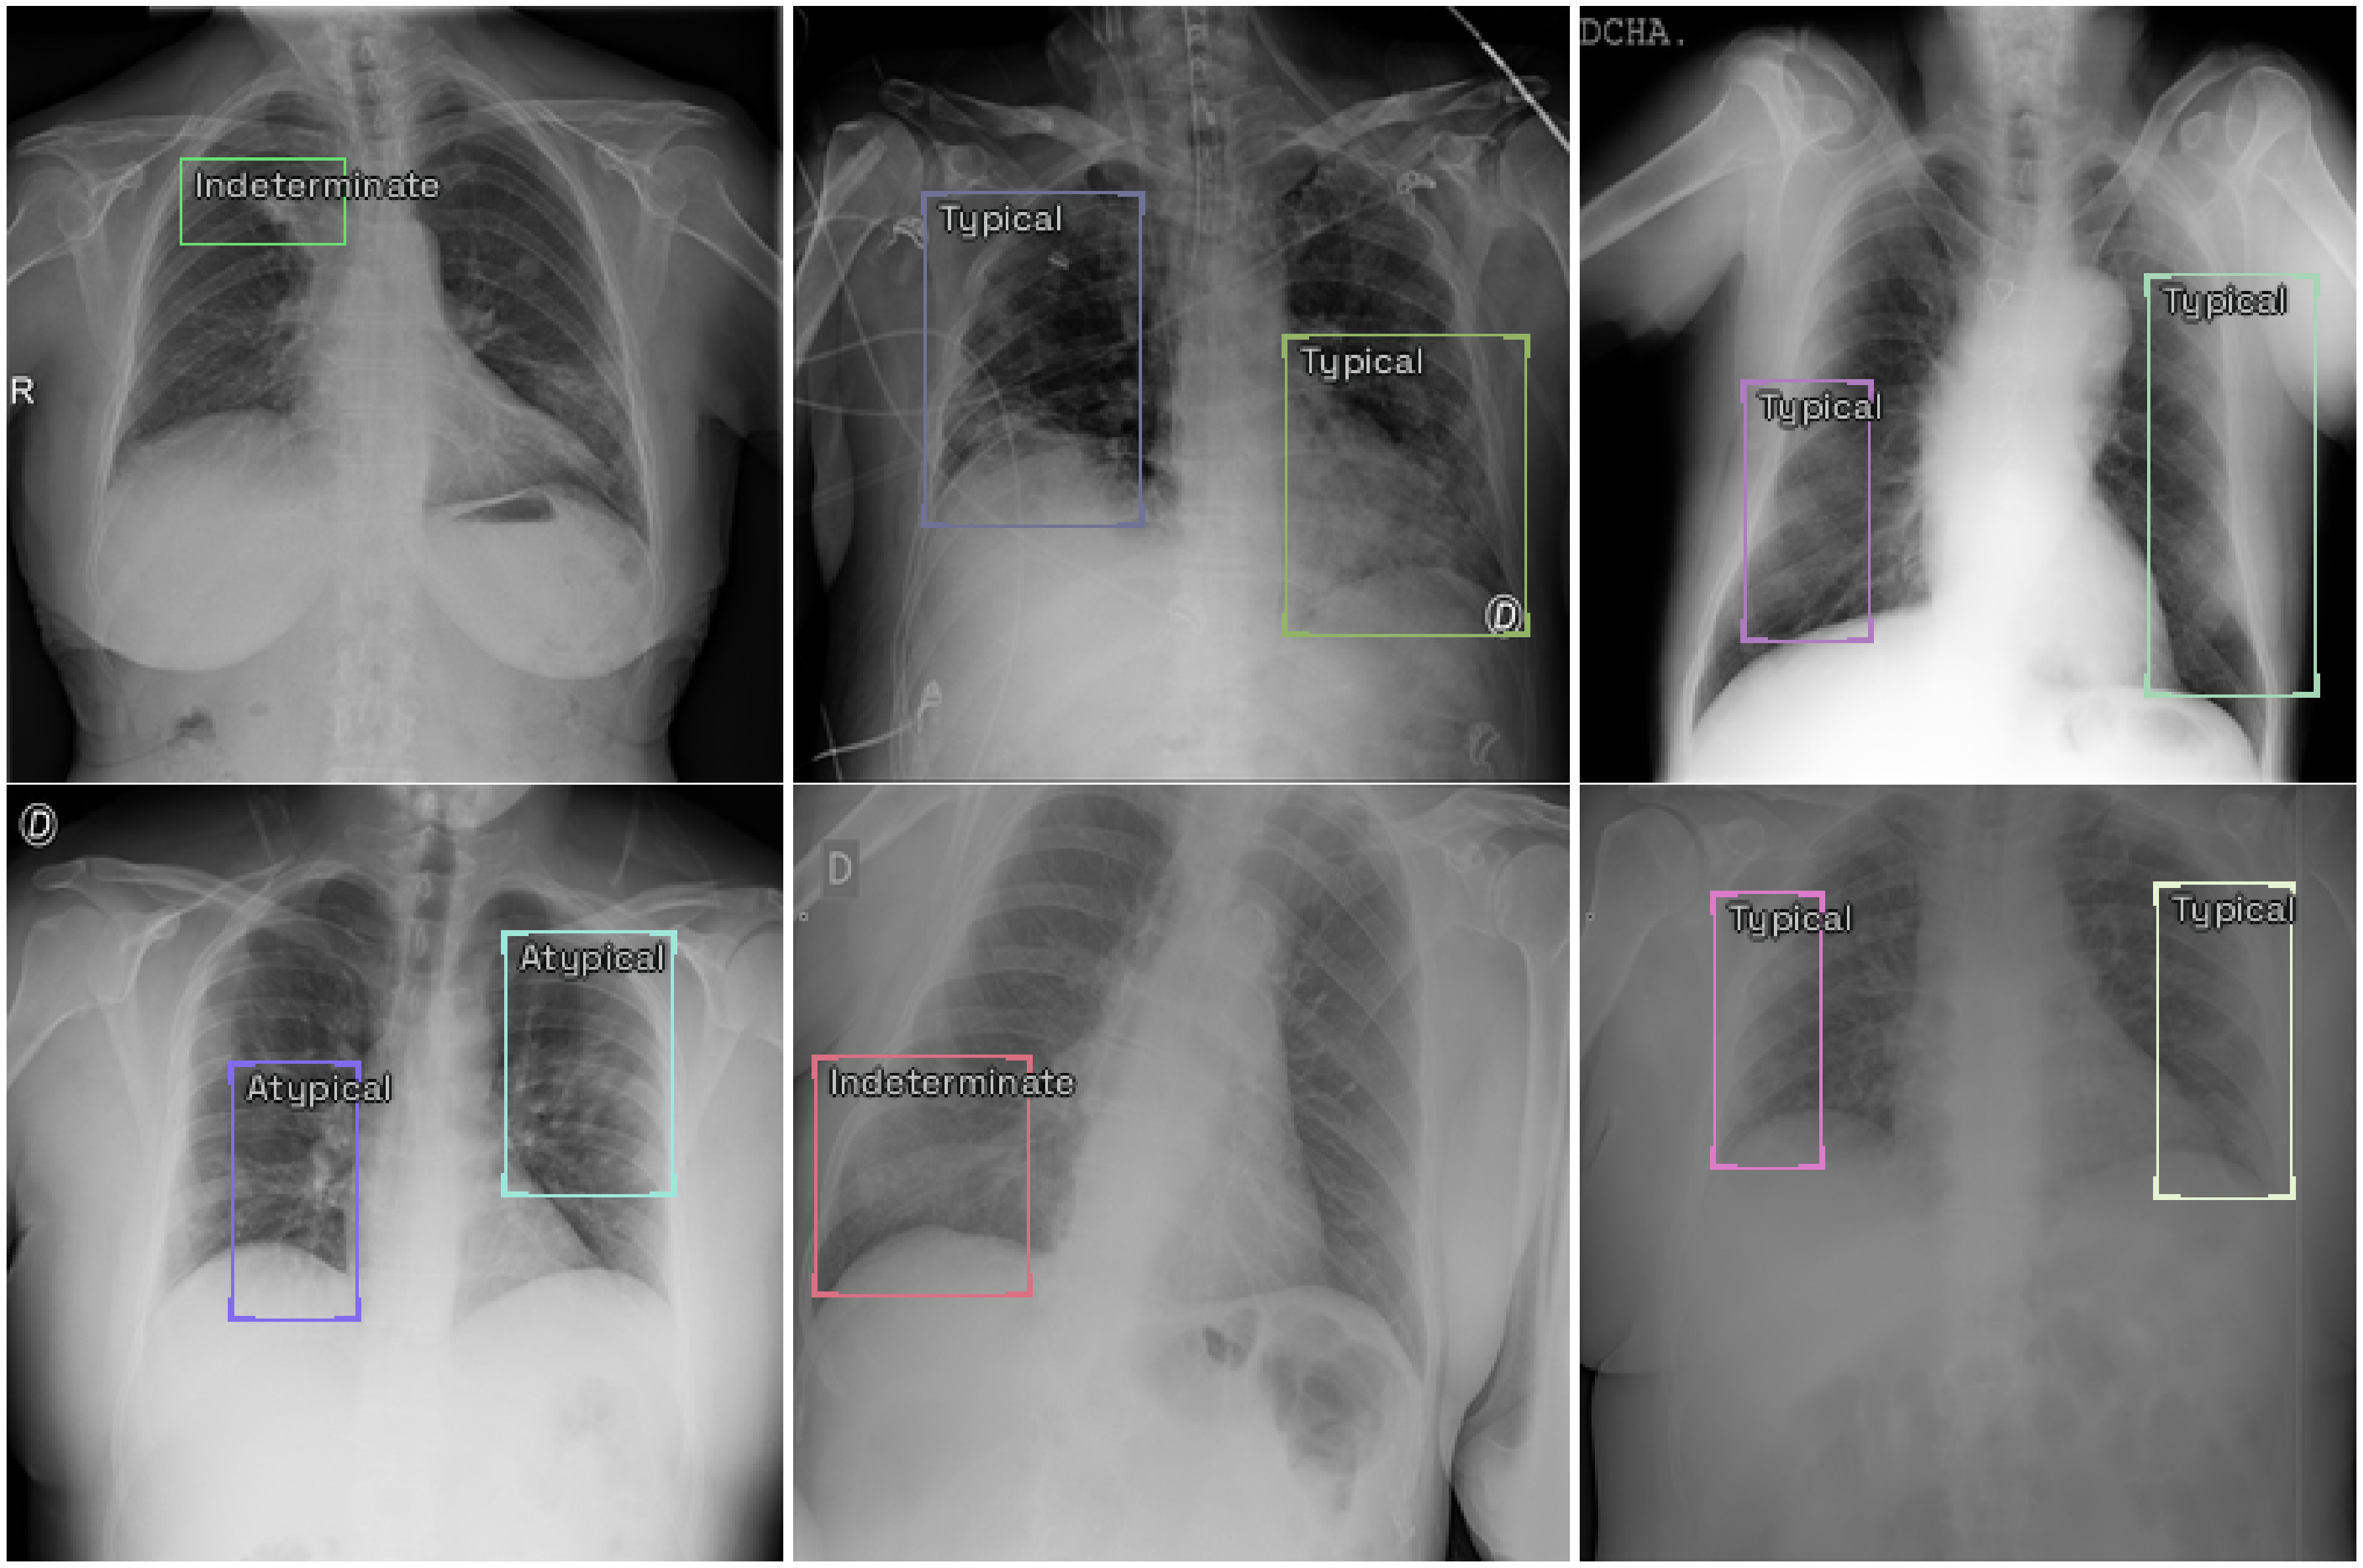

In [7]:
show_records(train_rs[:6], ncols=3, class_map=class_map)

In [8]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=params['size'], presize=params['size_trans']), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params['size']), tfms.A.Normalize()])

In [9]:
# Datasets
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

### Model Selection

In [10]:
# Just change the value of selection to try another model

selection = 3

extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
#   backbone = model_type.backbones.tf_lite0
  backbone = model_type.backbones.tf_d0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = params['size']

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = params['size']

model_type, backbone, extra_args

(<module 'icevision.models.ultralytics.yolov5' from '/opt/conda/lib/python3.7/site-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 {'img_size': 256})

In [12]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args) 

In [13]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=params['batch_size'], num_workers=0, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=params['batch_size'], num_workers=0, shuffle=False)

In [ ]:
# model_type.show_batch(first(valid_dl), ncols=4)

## Model & Parameter Setup

In [14]:
params['run_datetime'] = datetime.now(pytz.timezone('US/Pacific')).strftime("%m%d%Y-%H%M")


model_save_name = 'ModelName' + '_'  
model_save_name += str(len(parser.class_map)) + 'cls_' 
model_save_name += str((params['size'])) + 'px_'
model_save_name += str(len(train_ds)) + 'ds_'
model_save_name += params['run_datetime']
print(model_save_name)

ModelName_5cls_256px_3292ds_06152021-1525


In [15]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [16]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Model Training - Round 1

In [ ]:
# learn.freeze()
learn.lr_find()

In [17]:
params.update(lr1 = 1e-3)
params.update (epochs1 = 1)

learn.fit_one_cycle(params['epochs1'], params['lr1'])

epoch,train_loss,valid_loss,COCOMetric,time
0,0.387680,0.404354,0.030096,01:02


In [ ]:
params.update(lr1 = 1e-3)
params.update (epochs1 = 15)

learn.fit(params['epochs1'], params['lr1'])

epoch,train_loss,valid_loss,COCOMetric,time


In [ ]:
params.update(current_saved_model='stage-1-' + model_save_name)
params['current_saved_model']
learn.save(path/ params['current_saved_model'])

## Review Model Run - Validation Images

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.3)